In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bidict import bidict
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

In [34]:
ENCODER = bidict({
    'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6,
    'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12,
    'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18,
    'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24,
    'Y': 25, 'Z': 26
})

In [35]:
labels = np.load('../data/labels.npy')
labels = np.array([ENCODER[x] for x in labels])
labels.shape

(338,)

In [36]:
imgs = np.load('../data/images.npy')
imgs = imgs.astype("float32") / 405
imgs.shape

(337, 50, 50)

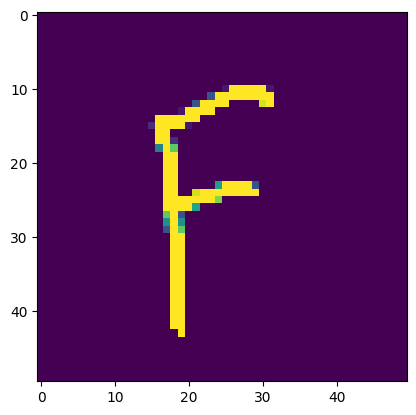

In [37]:
plt.figure()
plt.imshow(imgs[5])
plt.grid(False)
plt.show()

In [38]:
imgs = np.expand_dims(imgs, -1)

In [39]:
min_length = min(len(labels), len(imgs))
labels, imgs = shuffle(labels[:min_length], imgs[:min_length])
split = .75

labels_train = labels[:int(min_length * split)]
labels_test = labels[int(min_length * split):]

imgs_train = imgs[:int(min_length * split)]
imgs_test = imgs[int(min_length * split):]

In [40]:
batch_size = 16
epochs = 20

model = keras.Sequential([
    keras.Input(shape=(50, 50, 1)),
    layers.Conv2D(256, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Conv2D(512, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Conv2D(1024, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(len(ENCODER)+1, activation='softmax')
])

In [41]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)
optimizer = keras.optimizers.Adam()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [42]:
model.fit(imgs_train,
          labels_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(imgs_test, labels_test),
          callbacks=[early_stopping])

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.0246 - loss: 3.4310 - val_accuracy: 0.0353 - val_loss: 3.2742
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.0807 - loss: 3.1902 - val_accuracy: 0.2588 - val_loss: 2.6641
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4712 - loss: 1.8998 - val_accuracy: 0.5059 - val_loss: 1.8335
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6831 - loss: 0.9997 - val_accuracy: 0.6000 - val_loss: 1.6934
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7869 - loss: 0.5550 - val_accuracy: 0.6000 - val_loss: 1.8499
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9194 - loss: 0.3228 - val_accuracy: 0.6588 - val_loss: 1.8475
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9705 - loss: 0.1331 - val_accuracy: 0.6824 - val_loss: 2.0939
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9878 - loss: 0.0860 - val_accuracy: 0.6000 - val_loss:

In [43]:
labels_pred = np.argmax(model.predict(imgs_test), axis=-1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 503ms/step


In [44]:
cm = confusion_matrix(labels_test, labels_pred, labels=list(ENCODER.inverse.keys()))

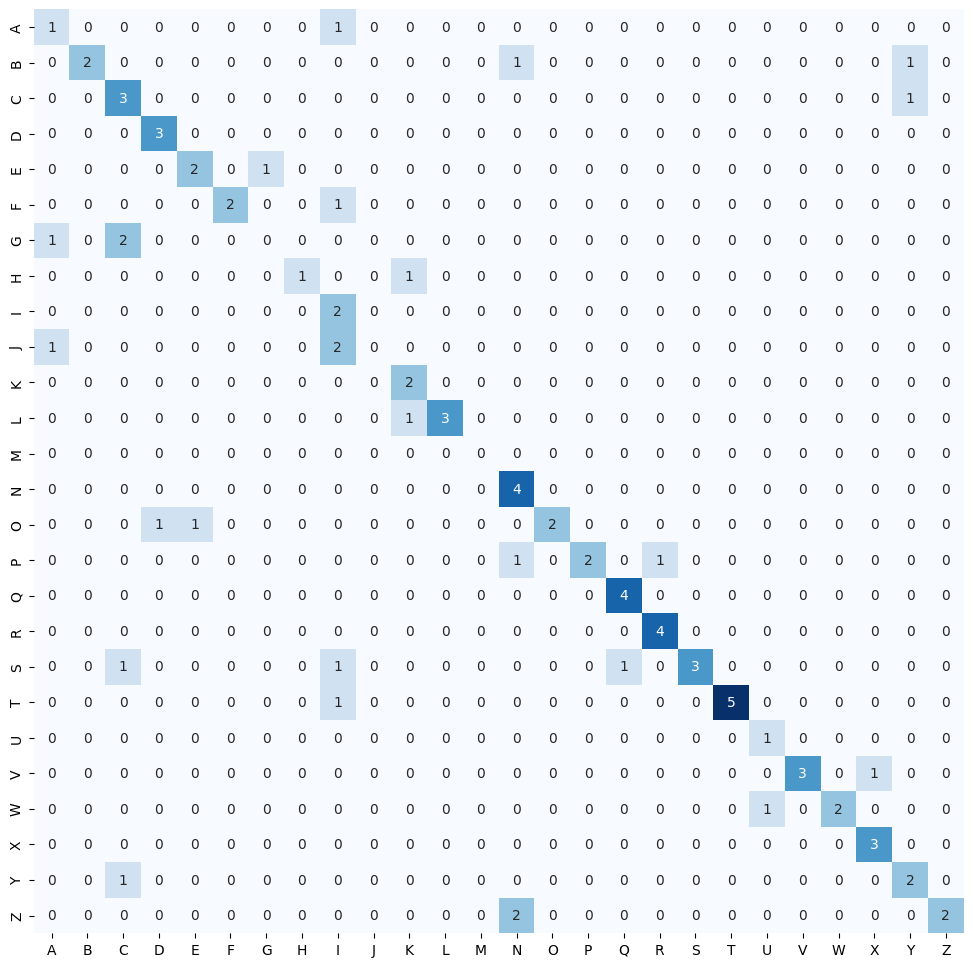

In [45]:
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, cbar=False, cmap="Blues", xticklabels=list(ENCODER.keys()), yticklabels=list(ENCODER.keys()))
plt.show()

In [46]:
model.save('../letter.keras')